## IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
import preprocess_kgptalkie as ps
import gensim

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

## READ DATASETS

In [3]:
fake = pd.read_csv('Fake (Dataset Collection 1).csv')

In [4]:
true = pd.read_csv('True (Dataset Collection 1).csv')

In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [7]:
fake.shape

(23481, 4)

In [8]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

<AxesSubplot:xlabel='subject', ylabel='count'>

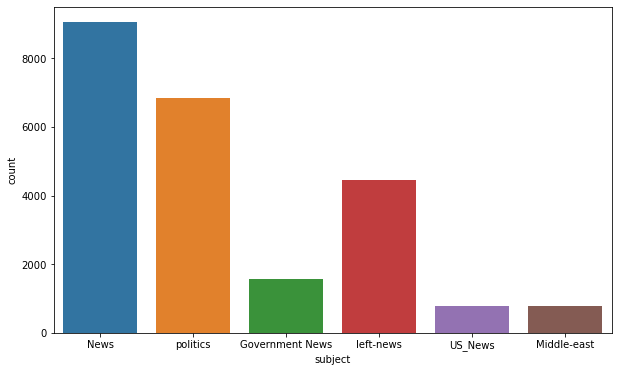

In [9]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'subject', data = fake)

In [10]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17


In [11]:
true.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [12]:
true.shape

(21416, 4)

In [13]:
true['subject'].value_counts()

politicsNews    11271
worldnews       10145
Name: subject, dtype: int64

<AxesSubplot:xlabel='subject', ylabel='count'>

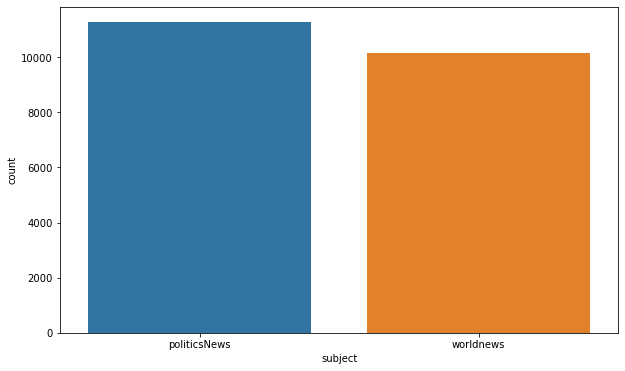

In [14]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'subject', data = true)

## Data Preprocessing

Find news stories with no text

In [15]:
text = ' '.join(fake['text'].tolist())

In [16]:
empty_fake_index = [index for index, text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [17]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


Combine title and text into one column

In [18]:
true['text'] = true['title'] + " " + true['text']

In [19]:
fake['text'] = fake['title'] + " " + fake['text']

Set all text as lower case

In [20]:
true['text'] = true['text'].apply(lambda x: str(x).lower())

In [21]:
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

set 'True' classifier as 0 and 'Fake' classifier as 1

In [22]:
true['class'] = 0
fake['class'] = 1

In [23]:
true.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

In [24]:
fake.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

Remove all columns except text and class

In [25]:
true = true[['text', 'class']]

In [26]:
fake = fake[['text', 'class']]

In [27]:
true.shape

(21416, 2)

In [28]:
fake.shape

(23481, 2)

combine fake and true datasets into one dataset

In [29]:
data = true.append(fake, ignore_index = True)

In [30]:
data.sample(5)

,text,class
27182,paul ryan responds to dem’s sit-in on gun con...,1
44477,ep #9: patrick henningsen live – ‘our western ...,1
15258,turkey detains more than 160 islamic state sus...,0
36945,obama’s revealing letter to brother tells why ...,1
20979,"in athens, macron to urge renewal of eu democr...",0


remove special characters from text

In [31]:
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

In [32]:
data.head()

,text,class
0,as us budget fight looms republicans flip thei...,0
1,us military to accept transgender recruits on ...,0
2,senior us republican senator let mr mueller do...,0
3,fbi russia probe helped by australian diplomat...,0
4,trump wants postal service to charge much more...,0


Separate the dataset where z holds all text that will be converted into vectors and y holds the truth values of every news story

In [33]:
z = [d.split() for d in data['text'].tolist()]

In [34]:
y = data['class'].values

In [35]:
type(z)

list

In [36]:
print(z[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'washington', 'reuters', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked',

## Word2Vec Model

Define word2vec model with the input being the list of text of news stories, the vector size, window which determines how many words are taken in a batch and a min count of 1 to ensure that a vector is generated for every word

In [37]:
dim = 250
w2v = gensim.models.Word2Vec(sentences=z, vector_size=dim, window=10, min_count=1)

Determine how many vectors were created

In [38]:
len(w2v.wv.index_to_key)

232476

In [39]:
w2v.wv.get_index('china')

207

In [40]:
w2v.wv['china']

array([-0.2132738 ,  1.2396822 ,  0.04667985,  0.72127384,  2.4992862 ,
       -2.7478206 ,  3.6387134 ,  0.45564863,  0.7276931 , -4.3494105 ,
       -2.5514033 , -0.07996439,  0.73364097,  3.4170797 ,  1.6749748 ,
        2.239609  , -1.7002984 , -0.4438794 ,  5.078015  , -0.25158134,
       -4.2060175 ,  1.1764579 , -0.11358631,  1.1996934 ,  3.7361708 ,
        3.492216  , -0.95242614, -3.1239622 ,  1.6407095 , -1.284165  ,
        1.1105186 , -2.5253286 ,  2.4418273 , -1.0234172 , -0.8594756 ,
       -3.13768   , -0.8860933 , -2.7883437 ,  0.16644238,  0.5616882 ,
       -0.23893039,  1.2543898 ,  0.37293598, -2.2375662 ,  0.910707  ,
       -1.2863638 , -1.3782985 ,  1.093614  ,  1.7124447 , -0.42631707,
       -1.889313  , -3.8341389 ,  3.2969365 ,  1.0654701 ,  2.5361915 ,
        0.95320034, -2.828686  ,  6.176611  , -0.17857683,  0.92683613,
        1.5857867 ,  0.12173925, -0.19467936,  1.7974782 ,  0.23417725,
        2.8461144 ,  0.4268564 , -0.5725131 ,  0.46415207, -0.74

In [41]:
w2v.wv.most_similar('china')

[('beijing', 0.7634618878364563),
 ('taiwan', 0.7214811444282532),
 ('chinas', 0.6907875537872314),
 ('chinese', 0.6607072353363037),
 ('xi', 0.6002225875854492),
 ('pyongyang', 0.5874906182289124),
 ('india', 0.5771642327308655),
 ('japan', 0.5652620792388916),
 ('taipei', 0.5636759400367737),
 ('beijings', 0.5550145506858826)]

Define tokenizer and feed text into it

In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(z)

Convert text into sequences

In [43]:
z = tokenizer.texts_to_sequences(z)

Determine the total number of words in a news story

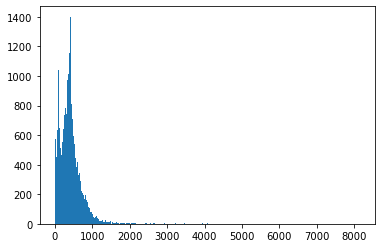

In [44]:
plt.hist([len(x) for x in z], bins = 700)
plt.show()

Find number of news stories that are more than 1000 words

In [45]:
nos = np.array([len(x) for x in z])
len(nos[nos > 1000])

1592

Ensure that all news stories have 1000 words. Pad if less than 1000, truncate if more than 1000

In [46]:
maxlen = 1000
z = pad_sequences(z, maxlen = maxlen)

In [47]:
len(z[101])

1000

Add 1 to the vocabulary so that if the model finds an unkwown word, it creates a new sequence for those unknown words

In [48]:
vocab_size = len(tokenizer.word_index) + 1

In [49]:
vocab = tokenizer.word_index

Obtain initial weight of vectors for use in LSTM model

In [50]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, dim))
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [51]:
embedding_vectors = get_weight_matrix(w2v)

In [52]:
embedding_vectors.shape

(232477, 250)

## LSTM Model

Define model

In [53]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = dim, weights = [embedding_vectors], input_length = maxlen, trainable = True))
model.add(LSTM(units = 128))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 250)         58119250  
                                                                 
 lstm (LSTM)                 (None, 128)               194048    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 58,313,427
Trainable params: 58,313,427
Non-trainable params: 0
_________________________________________________________________


Create train:test split of 75:25

In [55]:
z_train, z_test, y_train, y_test = train_test_split(z,y)

Train model

In [56]:
system = model.fit(z_train,y_train, validation_split=0.3, epochs=6)

Epoch 1/6
737/737 [==============================] - 1334s 2s/step - loss: 0.1153 - acc: 0.9593 - val_loss: 0.0231 - val_acc: 0.9938
Epoch 2/6
737/737 [==============================] - 1286s 2s/step - loss: 0.0151 - acc: 0.9958 - val_loss: 0.0119 - val_acc: 0.9968
Epoch 3/6
737/737 [==============================] - 1291s 2s/step - loss: 0.0068 - acc: 0.9980 - val_loss: 0.0108 - val_acc: 0.9968
Epoch 4/6
737/737 [==============================] - 1289s 2s/step - loss: 0.0159 - acc: 0.9952 - val_loss: 0.0097 - val_acc: 0.9978
Epoch 5/6
737/737 [==============================] - 1287s 2s/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0094 - val_acc: 0.9975
Epoch 6/6
737/737 [==============================] - 1289s 2s/step - loss: 0.0029 - acc: 0.9992 - val_loss: 0.0080 - val_acc: 0.9978


In [57]:
print(system.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


Plot training and validation accuracy and loss

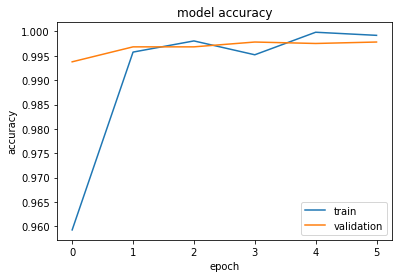

In [58]:
plt.plot(system.history['acc'])
plt.plot(system.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

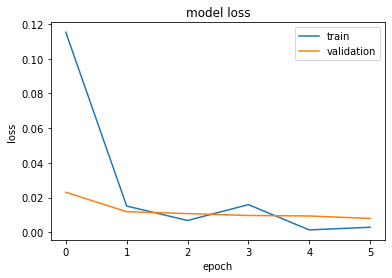

In [59]:
plt.plot(system.history['loss'])
plt.plot(system.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Test model with test split

In [60]:
y_pred = (model.predict(z_test) >= 0.5).astype(int)

In [61]:
accuracy_score(y_test, y_pred)

0.9975946547884187

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5276
           1       1.00      1.00      1.00      5949

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Test model with Test Dataset

In [63]:
test = pd.read_csv('test.csv')

In [64]:
values = pd.read_csv('Truth Values.csv')

In [65]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [66]:
values.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [67]:
test['text'] = test['text'].apply(lambda x: str(x).lower())

In [68]:
test['text'] = test['text'].apply(lambda x: ps.remove_special_chars(x))

In [69]:
test['text'].head()

0    palo alto calif after years of scorning the po...
1    russian warships ready to strike terrorists ne...
2    videos nodapl native american leaders vow to s...
3    if at first you dont succeed try a different s...
4    42 mins ago 1 views 0 comments 0 likes for the...
Name: text, dtype: object

In [70]:
x = test['text']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen = maxlen)
results = (model.predict(x) >= 0.5).astype(int)

In [71]:
test_values = values['label'].values

In [72]:
accuracy_score(test_values, results)

0.6326923076923077

In [73]:
print(classification_report(test_values, results))

              precision    recall  f1-score   support

           0       0.73      0.44      0.55      2656
           1       0.59      0.83      0.69      2544

    accuracy                           0.63      5200
   macro avg       0.66      0.64      0.62      5200
weighted avg       0.66      0.63      0.62      5200



In [74]:
final_results = pd.DataFrame()
final_results['id'] = test['id']
final_results['label'] = results
final_results.to_csv('Results (Dataset Collection 1).csv', index = False)